In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl

In [25]:
campaign = 1
epicid = "201367065"
# epicid = "201912552"
# epicid = "201649426"
basepath = "/Users/dfm/data/k2"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=1975.0,
    skip=50,
#     initial_time=2015.,
#     skip=0,
    durations=[0.05, 0.1, 0.2],
    min_period=3.,
    max_period=50.,
    npeaks=4,
    # use_gp=False,
)

In [26]:
pipe = ketu.k2.Data(cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True, clobber=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True, clobber=True)
pipe = ketu.Vetter(pipe, cache=False)

In [27]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 0.50s
Querying Likelihood
tau = 9.42840576172
tau = 9.42840576172
tau = 7.67486572266
tau = 7.67993164062
Finished querying Likelihood in 4.02s
Querying OneDSearch
Finished querying OneDSearch in 43.48s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 147.08s
Querying Vetter
Finished querying Vetter in 8.70s


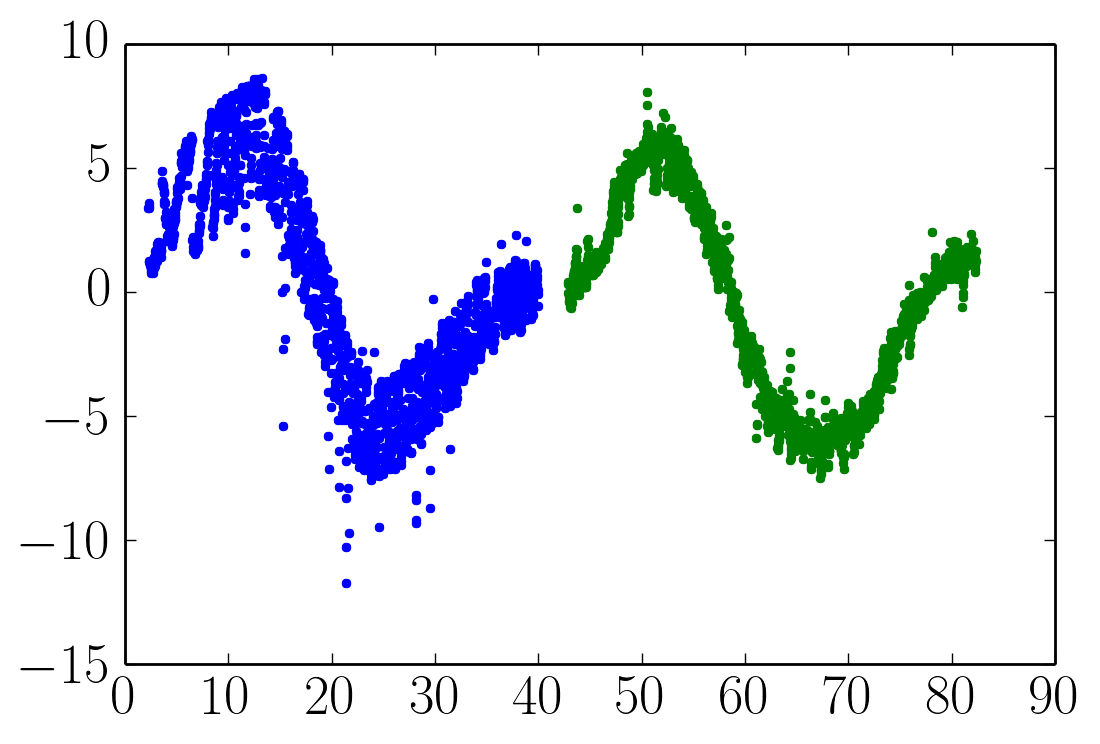

In [28]:
lcs = r.model_light_curves
[pl.plot(lc.time, lc.flux, ".") for lc in lcs];

In [29]:
lc = lcs[0]

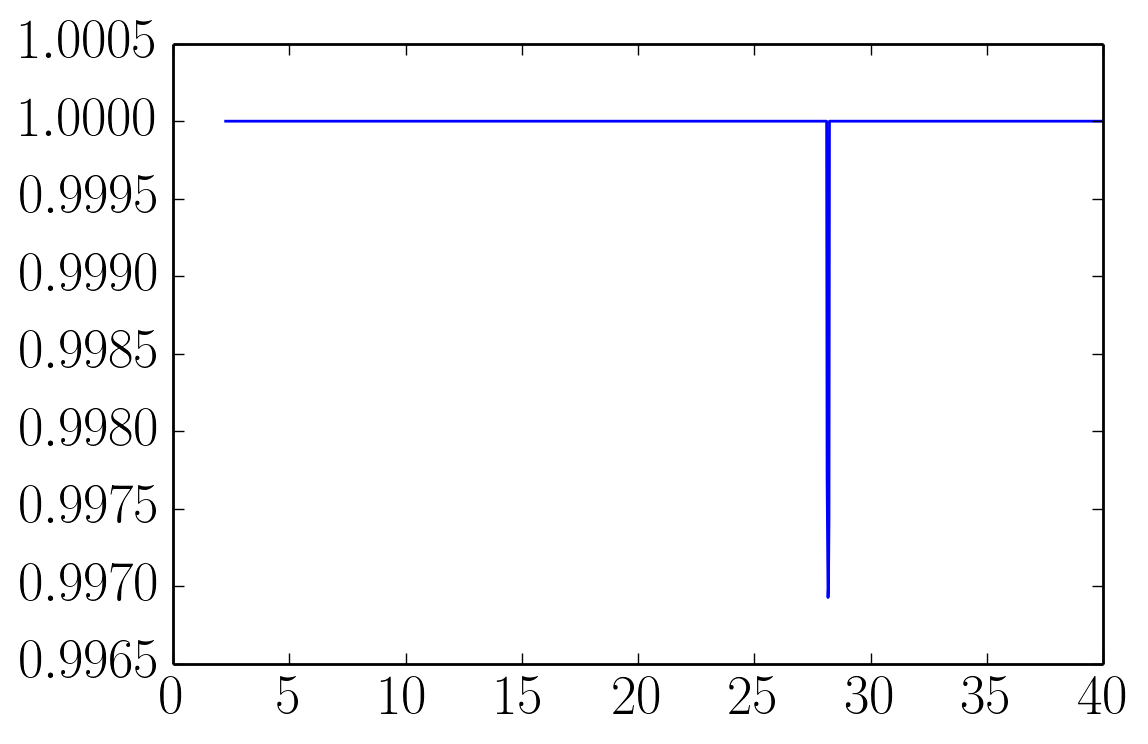

In [30]:
from transit import SimpleSystem
p = r.peaks[0]
s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

pl.plot(lc.time, s.light_curve(lc.time))

In [31]:
r.peaks

[{'depth': 2.4925816697621599,
  'depth_ivar': 89.303667698992797,
  'duration': 0.1,
  'lnZ_box': -767.47842634661527,
  'lnZ_none': -905.94990374586723,
  'lnZ_transit': -617.60176872483021,
  'lnlike_box': -766.14073882468438,
  'lnlike_none': -905.94990374586723,
  'lnlike_transit': -599.73814940092268,
  'period': 32.903330091070892,
  'phic_same': -1588.0607558187346,
  'phic_same_second': -1661.0925400739241,
  'phic_variable': -3456.5851232525952,
  's2n': 23.555050777960915,
  't0': 28.187207031249596,
  'transit_b': 0.0,
  'transit_duration': 0.10632112479926929,
  'transit_period': 32.940227462558916,
  'transit_q1': 0.49947573286541558,
  'transit_q2': 0.49979559468060475,
  'transit_ror': 0.050644672521851251,
  'transit_t0': 28.173149067113776},
 {'depth': 0.067896047242837279,
  'depth_ivar': 1694.8435140057336,
  'duration': 0.2,
  'lnZ_box': -595.87578010206289,
  'lnZ_none': -599.73803506744548,
  'lnZ_transit': -606.93384287890603,
  'lnlike_box': -593.05526546798478

(25.173149067113776, 31.173149067113776)

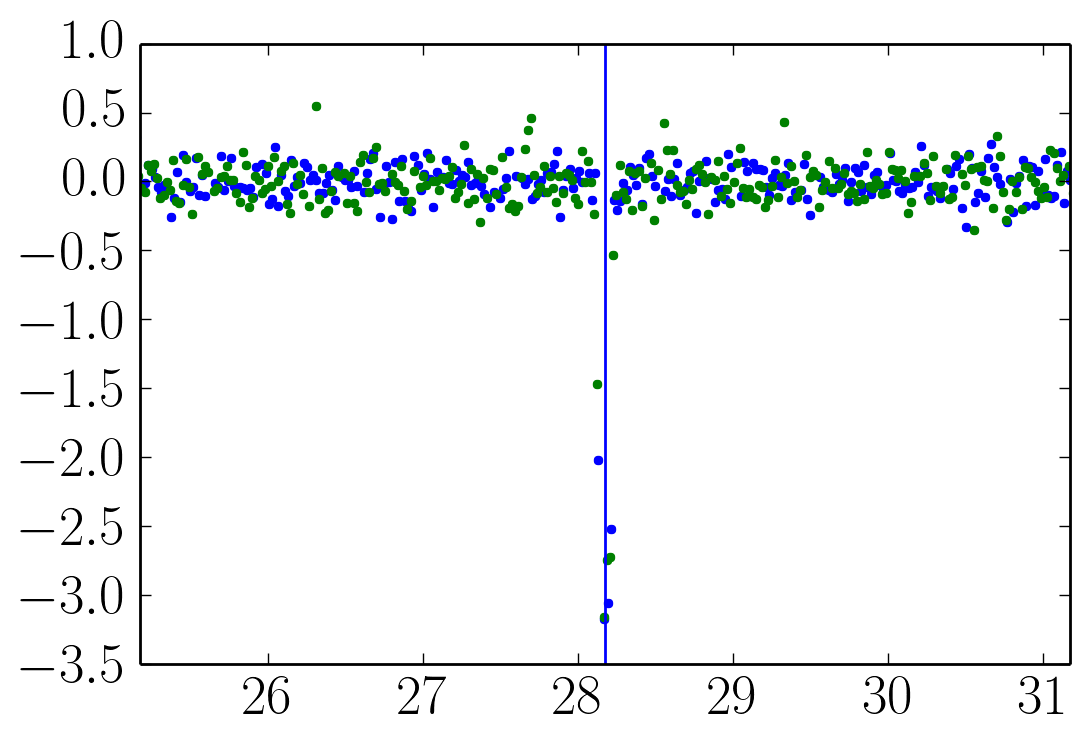

In [33]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

[pl.plot(lc.time % (p["transit_period"]), lc.flux - lc.predict(lc.flux - 1e3*(s.light_curve(lc.time)-1.0)), ".") for lc in lcs]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-3, p["transit_t0"]+3)